In [ ]:
!pip install trimesh open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.8/693.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Maestria/ULTIMO SEMESTRE/MyPointNet'

/content/drive/MyDrive/Maestria/ULTIMO SEMESTRE/MyPointNet


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import open3d as o3d
tf.random.set_seed(1234)

In [ ]:
# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


In [ ]:
DATA_DIR = '/content/drive/MyDrive/Maestria/ULTIMO SEMESTRE/MyPointNet/Datasets/'

In [ ]:
def standardize_points(points, num_points):
  if len(points) > num_points:
    # Subsample points randomly if there are too many
    indices = np.random.choice(len(points), num_points, replace=False)
    return points[indices]

  elif points.shape[0] < num_points:
    # Pad with zeros if there are not enough points
    additional_points = num_points - points.shape[0]
    padding = np.zeros((additional_points, points.shape[1]))
    return np.vstack([points, padding])
  return points

In [ ]:
def parse_dataset(num_points=15000, DATA_DIR='/content/drive/MyDrive/Maestria/ULTIMO SEMESTRE/MyPointNet/Datasets/'):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))  # Avoids README.txt
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = os.path.basename(folder)
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            if f.endswith('.ply'):
                mesh = trimesh.load(f, process=False)
                if isinstance(mesh, trimesh.PointCloud):
                    points = mesh.vertices
                else:
                    points = mesh.sample(num_points)
                points = standardize_points(points, num_points)
                train_points.append(points)
                train_labels.append(i)

            elif f.endswith('.off'):
                mesh = trimesh.load(f, process=False)
                points = mesh.sample(num_points)
                points = standardize_points(points, num_points)
                train_points.append(points)
                train_labels.append(i)

        for f in test_files:
            if f.endswith('.ply'):
                mesh = trimesh.load(f, process=False)
                if isinstance(mesh, trimesh.PointCloud):
                    points = mesh.vertices
                else:
                    points = mesh.sample(num_points)
                points = standardize_points(points, num_points)
                test_points.append(points)
                test_labels.append(i)

            elif f.endswith('.off'):
                mesh = trimesh.load(f, process=False)
                points = mesh.sample(num_points)
                points = standardize_points(points, num_points)
                test_points.append(points)
                test_labels.append(i)

    return (
        np.array(train_points),
        np.array(train_labels),
        np.array(test_points),
        np.array(test_labels),
        class_map,
    )


In [ ]:
parse_dataset()

processing class: bell_pepper_proc
processing class: not_bell_pepper


(array([[[ 1.93236190e-02, -2.61028663e-02,  5.69846287e-03],
         [ 2.34818400e-04, -1.29083826e-02,  1.56984533e-02],
         [-2.23313654e-03,  2.78581199e-02,  1.06984581e-02],
         ...,
         [-2.08546735e-02, -1.20396081e-02,  5.69846287e-03],
         [-3.54353460e-02, -5.65873649e-03,  3.69845881e-03],
         [-1.73238549e-02, -6.03717721e-03,  9.69847097e-03]],
 
        [[ 1.76074153e-03,  5.49959771e-02, -1.27139598e-02],
         [ 2.62123284e-03,  5.49893956e-02, -1.37139469e-02],
         [ 3.32706768e-03,  5.49893956e-02, -1.37139469e-02],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[-3.82096386e-02,  8.88455153e-03, -9.97300029e-03],
         [-1.47903972e-02,  2.36619118e-02, -9.73026753e-04],
         [-2.99206014e-02, -3.06725822e-02, -9.73026753e-04],
         ...,
         [-1.47202590e

In [ ]:
NUM_POINTS = 15000
NUM_CLASSES = 2
BATCH_SIZE = 32

train_points, train_labels, test_points, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: bell_pepper_proc
processing class: not_bell_pepper


In [ ]:
def augment(points, label):
  # jitter points
  points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
  #shuffle points
  points = tf.random.shuffle(points)
  return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


In [ ]:
def conv_bn(x, filters):
  x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation("relu")(x)

def dense_bn(x, filters):
  x = layers.Dense(filters)(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
  def __init__(self, num_features, l2reg=0.001):
    self.num_features = num_features
    self.l2reg = l2reg
    self.eye = tf.eye(num_features)

  def __call__(self, x):
    x = tf.reshape(x, (-1, self.num_features, self.num_features))
    xxt = tf.tensordot(x, x, axes=(2,2))
    xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
    return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

# Create T-Net Layers

In [ ]:
def tnet(inputs, num_features):

  #Initialize bias as the identity matrix
  bias = keras.initializers.Constant(np.eye(num_features).flatten())
  reg = OrthogonalRegularizer(num_features)

  x = conv_bn(inputs, 32)
  x = conv_bn(x, 64)
  x = conv_bn(x, 512)
  x = layers.GlobalMaxPooling1D()(x)
  x = dense_bn(x, 256)
  x = dense_bn(x, 128)
  x = layers.Dense(
      num_features * num_features,
      kernel_initializer="zeros",
      bias_initializer=bias,
      activity_regularizer=reg,
  )(x)
  feat_T = layers.Reshape((num_features, num_features))(x)
  # Apply affine transformation to input features
  return layers.Dot(axes=(2,1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x,32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs = inputs, outputs = outputs, name = "pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15000, 3)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 32)            128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 15000, 32)            128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 15000, 32)            0         ['batch_normalization[0

In [ ]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
28/28 [==============================] - 30s 426ms/step - loss: 1.8804 - sparse_categorical_accuracy: 0.8830 - val_loss: 44830809811775913984.0000 - val_sparse_categorical_accuracy: 0.9891
Epoch 2/20
28/28 [==============================] - 10s 368ms/step - loss: 1.4001 - sparse_categorical_accuracy: 0.9484 - val_loss: 464040385195526370361344.0000 - val_sparse_categorical_accuracy: 0.9094
Epoch 3/20
28/28 [==============================] - 10s 369ms/step - loss: 1.3445 - sparse_categorical_accuracy: 0.9656 - val_loss: 44297599589600175587328.0000 - val_sparse_categorical_accuracy: 0.9384
Epoch 4/20
28/28 [==============================] - 10s 369ms/step - loss: 1.2019 - sparse_categorical_accuracy: 0.9862 - val_loss: 42775585084950970368.0000 - val_sparse_categorical_accuracy: 0.9891
Epoch 5/20
28/28 [==============================] - 10s 366ms/step - loss: 1.1909 - sparse_categorical_accuracy: 0.9828 - val_loss: 487931332700380510289920.0000 - val_sparse_categorical_accura

# Compile & Train the Model

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

1/1 [==============================] - 1s 1s/step


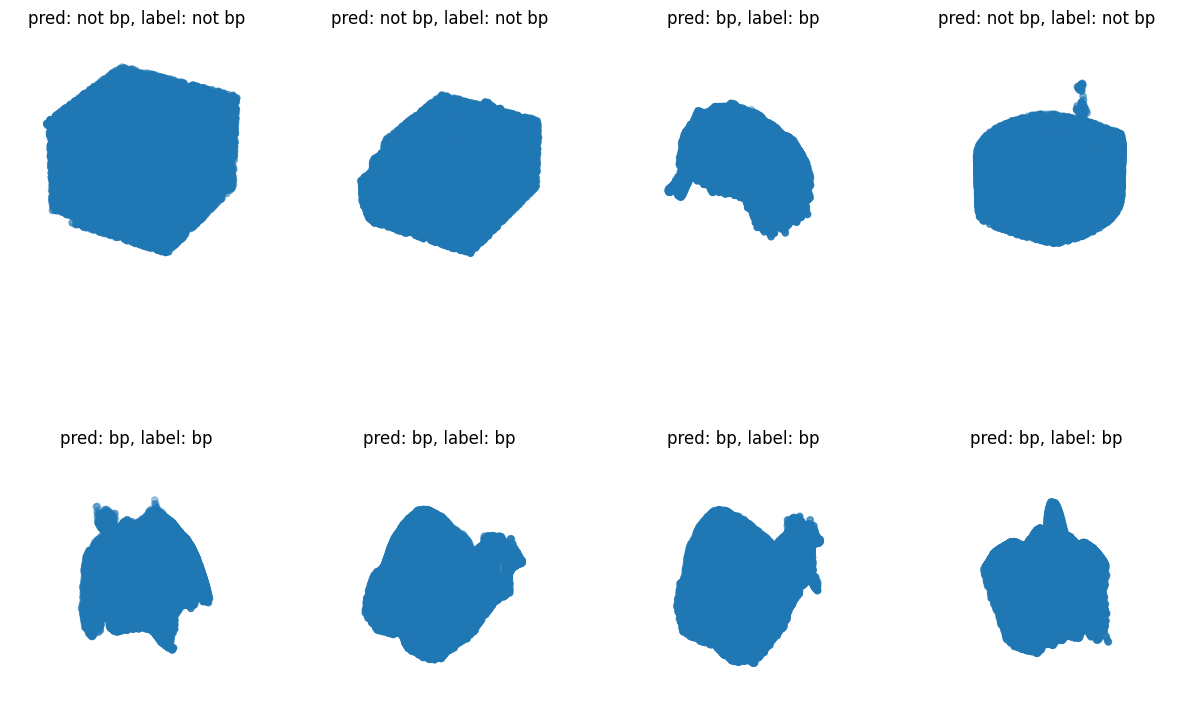

In [ ]:
# plot points with predicted class and label
fig = plt.figure(figsize=(15,10))
CLASS_MAP = {0: 'bp', 1: 'not bp'}
for i in range(8):
  ax = fig.add_subplot(2,4, i + 1, projection="3d")
  ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
  ax.set_title(
      "pred: {:}, label: {:}".format(
          CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
      )
  )
  ax.set_axis_off()
plt.show()

# Consider data augmentation.

In [ ]:
print(CLASS_MAP)

{0: 'bell_pepper_proc', 1: 'not_bell_pepper'}


In [ ]:
# Save weights to a HDF5 file
model.save_weights('my_weights.h5')

# Alternatively, save weights in the TensorFlow checkpoint format
model.save_weights('my_weights.ckpt', save_format='tf')


In [ ]:
# Save the entire model to a HDF5 file (includes architecture, weights, and optimizer state)
model.save('my_model.h5')

# Save in TensorFlow SavedModel format (recommended for TensorFlow models)
model.save('my_tf_model', save_format='tf')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: <__main__.OrthogonalRegularizer object at 0x78bec991add0> does not implement get_config()

In [ ]:
# Create a new model instance with the same architecture
new_model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
new_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"]
)

# Load the weights
new_model.load_weights('my_weights.h5')